In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [182]:
import pydicom as dcm
from glob import glob
import os
import cv2
from tqdm import tqdm

In [6]:
import sys
sys.path.append('..')
from utils import enorm

In [193]:
cxr1 = dcm.dcmread('../data/test/dcm/0053ee32-1e03-4dc2-a103-f46ad0448787.dcm')
cxr1 = cxr1.pixel_array.astype(np.float32)

In [108]:
cxr = cxr.pixel_array.astype(np.float32)

In [183]:
tdir = '../data/train'
for pth in tqdm(glob(os.path.join(tdir, 'dcm/*.dcm'))):
    image = dcm.dcmread(pth).pixel_array
    cv2.imwrite(os.path.join(tdir, 'png', os.path.basename(pth) + '.png'), image)


100%|██████████| 25684/25684 [11:35<00:00, 36.95it/s]


In [184]:
tdir = '../data/test'
for pth in tqdm(glob(os.path.join(tdir, 'dcm/*.dcm'))):
    image = dcm.dcmread(pth).pixel_array
    cv2.imwrite(os.path.join(tdir, 'png', os.path.basename(pth) + '.png'), image)


100%|██████████| 1000/1000 [00:27<00:00, 36.70it/s]


In [178]:
'../data/train/png/4db29f9a-caf0-49e5-af86-af16062bdbc7.dcm.png'

'../data/train/png/4db29f9a-caf0-49e5-af86-af16062bdbc7.dcm'

In [194]:
cxr1

array([[ 49.,  45.,  40., ..., 117., 115., 117.],
       [ 41.,  37.,  31., ..., 115., 113., 115.],
       [ 34.,  30.,  24., ..., 115., 113., 115.],
       ...,
       [ 77.,  79.,  81., ..., 138., 136., 134.],
       [ 78.,  81.,  83., ..., 139., 137., 134.],
       [ 79.,  82.,  85., ..., 140., 137., 135.]], dtype=float32)

In [83]:
masks = np.load('../data/ribs/RKB/ribs_masks/ribs_mask_01.npz')

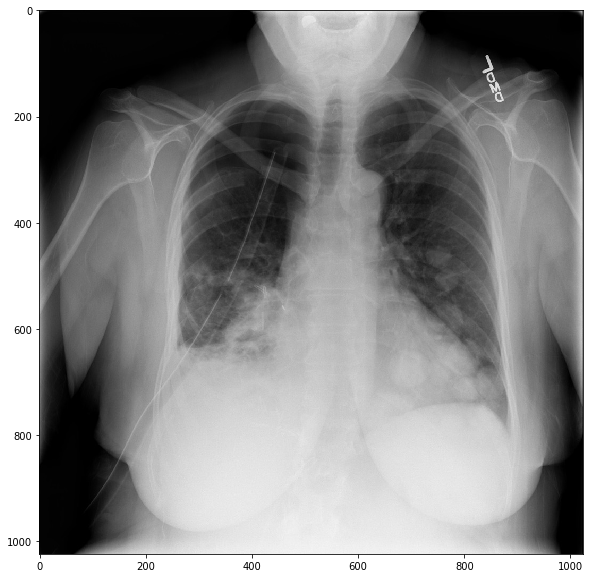

In [412]:
image = cv2.imread('../data/train/png/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm.png')
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap=plt.cm.bone)

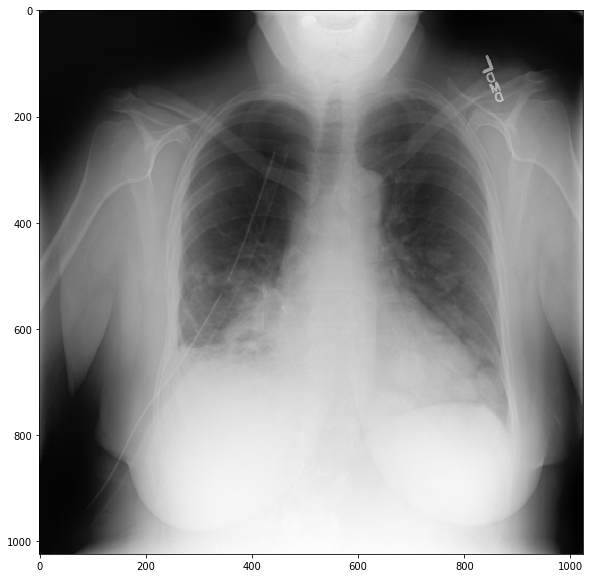

In [419]:
image = cv2.imread('../data/train/inversed/1/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm.png')
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap=plt.cm.bone)

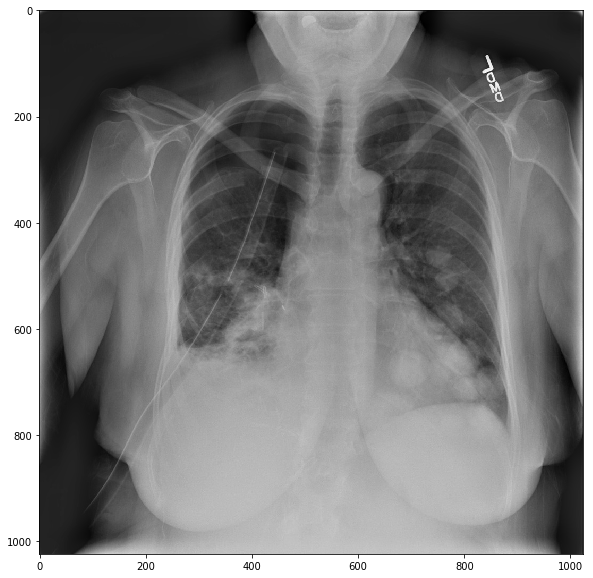

In [420]:
image = cv2.imread('../data/train/inversed/2/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm.png')
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap=plt.cm.bone)

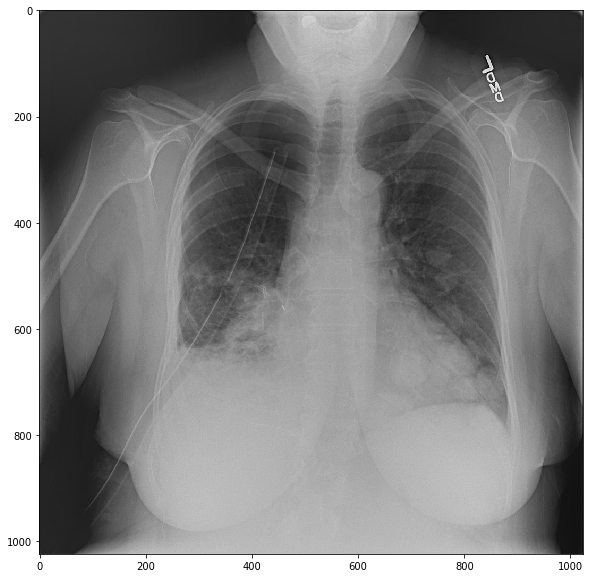

In [421]:
image = cv2.imread('../data/train/inversed/3/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm.png')
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap=plt.cm.bone)

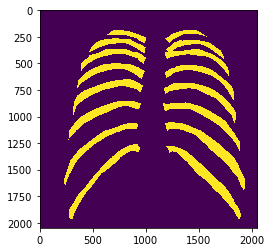

In [90]:
plt.imshow(masks['arr_0'])

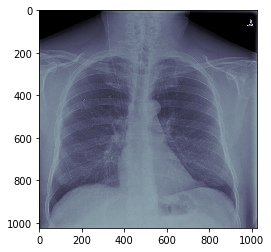

In [106]:
plt.imshow(cxr1, cmap=plt.cm.bone)

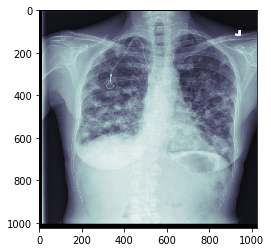

In [109]:
plt.imshow(cxr, cmap=plt.cm.bone)

In [226]:
"""
This is an implementation of localized energy-based normalization from paper proposed by:
R. H. H. M. Philipsen et al,
"Localized Energy-Based Normalization of Medical Images: Application to Chest Radiography" 
in IEEE Transactions on Medical Imaging.
doi: 10.1109/TMI.2015.2418031
URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7073580&isnumber=7229384
"""

from scipy.ndimage import filters
import numpy as np


class EnergyNormalization:
    def __init__(self, B=7, alpha=2, gamma=2):
        self.B = B
        self.alpha = alpha
        self.gamma = gamma

    def decompose(self, images):
        decomposed = []
        blured = [images]
        for i in range(self.B):
            blured += [[filters.gaussian_filter(img, self.alpha * self.gamma ** i) for img in images]]
            decomposed += [[old  - new
                           for old, new in zip(blured[i], blured[i + 1])]]
        decomposed += [blured[-1]]
        return list(zip(*decomposed))

    def get_energies(self, images, masks):
        energies = list()
        for img, mask in zip(images, masks):
            energies.append([
                np.std(layer[mask])
                for layer in img
            ])
        return energies

    def normalize(self, decomposed, masks, immutable=[], immutable_masks=[]):
        energies = self.get_energies(decomposed, masks)
        immutable_energies = self.get_energies(immutable, immutable_masks)

        referenced = np.asarray([
            e.mean() 
            for e in np.asarray(immutable_energies).T
        ])

        images = []
        diff = []
        for imgs, energy in zip(decomposed, energies):
            normalized = np.zeros(imgs[0].shape)
            for layer, e, ref in zip(imgs, energy, referenced):
                diff += [ref / e]
                normalized += layer * diff[-1]
            images += [normalized]

        return images, diff


    def iterate_normalization(self, images, masks, 
                              immutable=[], immutable_masks=[], 
                              n_iterations=10, verbose=True):
        decomposed_immutable = self.decompose(immutable)
        for i in range(n_iterations):
            decomposed = self.decompose(images)
            images, diff = self.normalize(decomposed, masks, decomposed_immutable, immutable_masks) 
            if verbose:
                print('Step: ', i, ', diff: ', np.mean(diff))
        return images


In [256]:
enm = EnergyNormalization(B=7, alpha=2, gamma=2)

In [248]:
d = enm.decompose([cxr])
d1 = enm.decompose([cxr1])

e = enm.get_energies(d, [mask])
e1 = enm.get_energies(d1, [mask1])

In [249]:
np.mean(np.array(e1) / np.array(e))

0.45841104

In [253]:
cxr2 = enm.iterate_normalization([cxr], [mask], [cxr1], [mask1], n_iterations=10)

Step:  0 , diff:  0.45841104
Step:  1 , diff:  0.9869698056644867
Step:  2 , diff:  0.9925918747475425
Step:  3 , diff:  0.9944486973986996
Step:  4 , diff:  0.9957413647823894
Step:  5 , diff:  0.9967932450876688
Step:  6 , diff:  0.9976227867888545
Step:  7 , diff:  0.9982543334771752
Step:  8 , diff:  0.9987269278301076
Step:  9 , diff:  0.9990796651684766


In [116]:
decomposed = enm.decompose([cxr])
decomposed1 = enm.decompose([cxr1])

In [125]:
import scipy

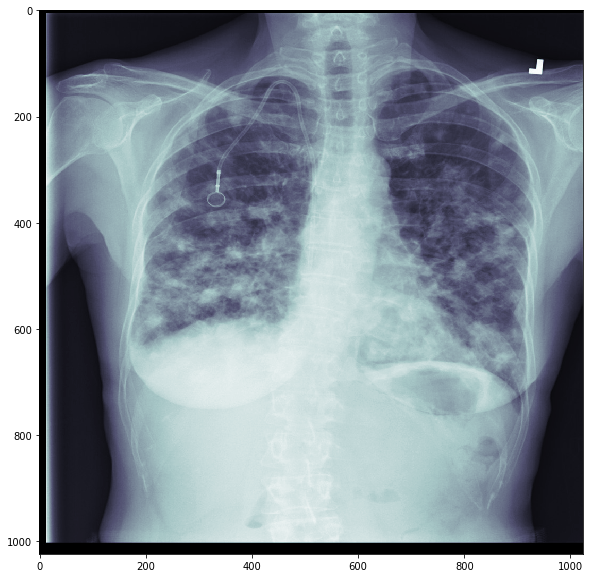

In [254]:
plt.figure(figsize=(10,10))
plt.imshow(cxr, cmap=plt.cm.bone)

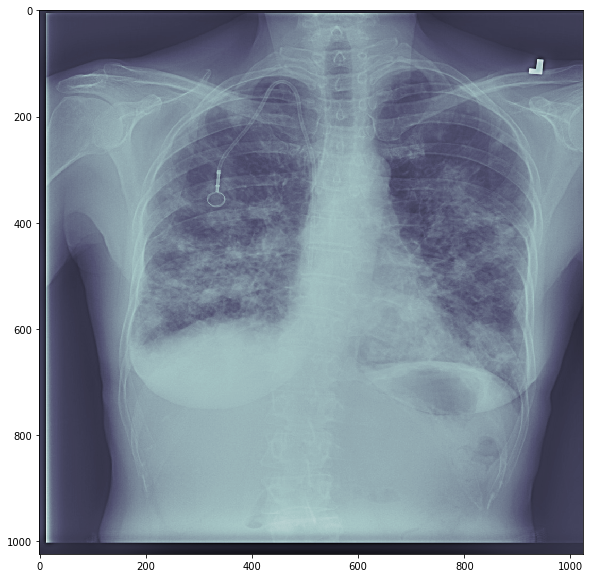

In [255]:
plt.figure(figsize=(10,10))
plt.imshow(cxr2[0], cmap=plt.cm.bone)

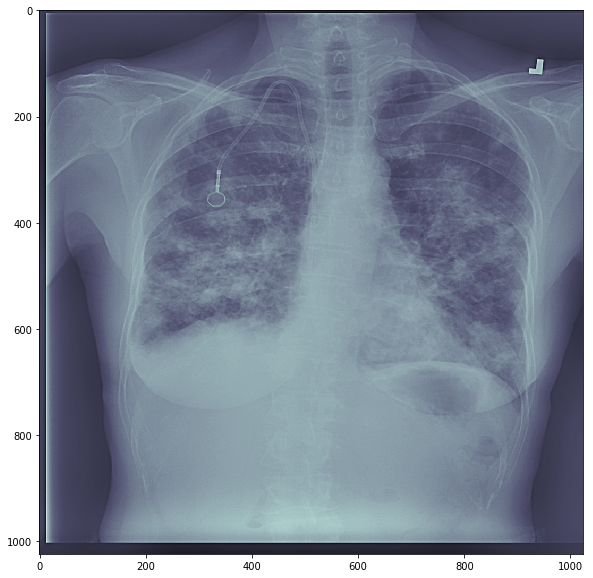

In [200]:
plt.figure(figsize=(10,10))
plt.imshow(cxr2[0], cmap=plt.cm.bone)

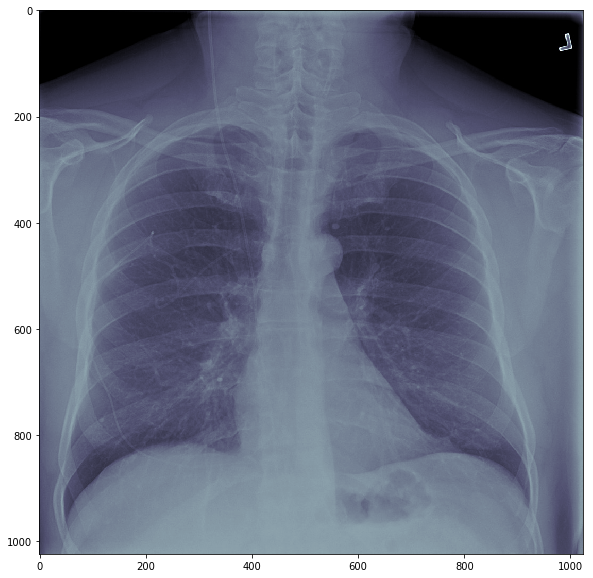

In [201]:
plt.figure(figsize=(10,10))
plt.imshow(cxr1, cmap=plt.cm.bone)

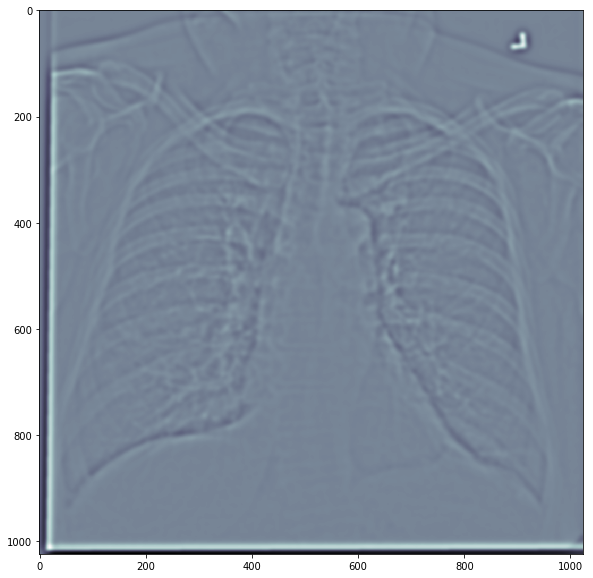

In [261]:
cxrd = np.load('../data/test/npz/00293de0-a530-41dc-9621-0b3def01d06d.dcm.npy')
plt.figure(figsize=(10,10))
plt.imshow(cxrd[2], cmap=plt.cm.bone)

## Cancer images

In [434]:
data = np.load('../data/cancer_images/data.npz')
y = data['y']
x = data['x']

In [440]:
np.rollaxis(x[0], 0, 3).shape

(1024, 1024, 3)

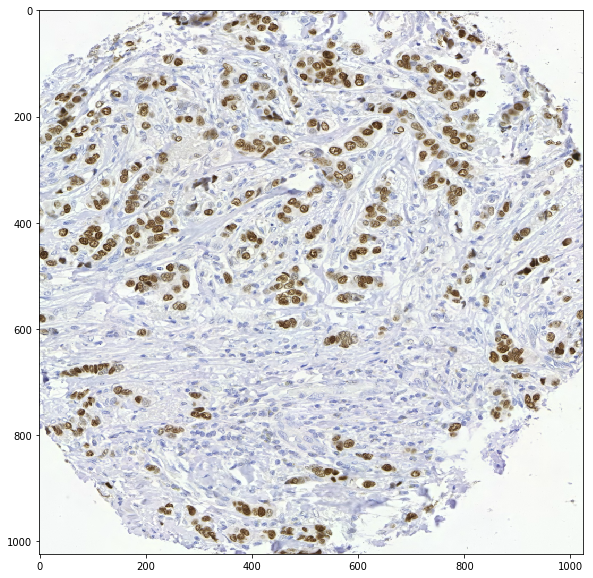

In [445]:
plt.figure(figsize=(10,10))
plt.imshow(np.rollaxis(x[6], 0, 3))

## Clavicles images

In [463]:
data = np.load('../data/clavicles/Indianapolis/clavicles_masks/clavicles_mask_001.mask.npz')
mask = data['arr_0']

In [464]:
data.keys()

['arr_0']

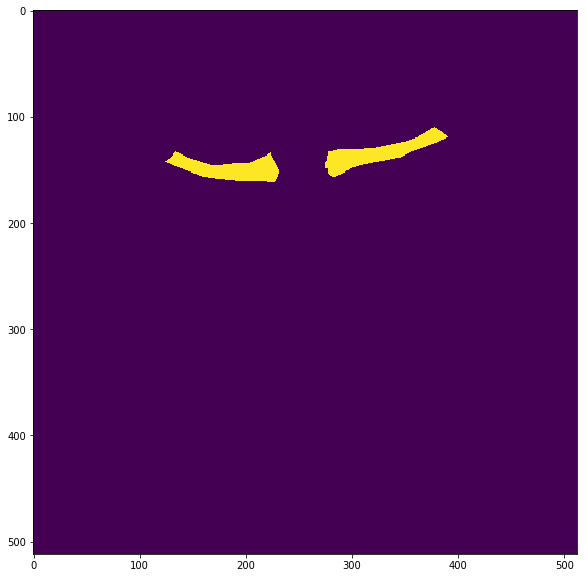

In [465]:
plt.figure(figsize=(10,10))
plt.imshow(mask)

In [450]:
data = json.load(open('../data/clavicles/Indianapolis/clavicles_masks/clavicles_mask_001.mask.npz)
data.keys()

dict_keys(['id', 'createdAt', 'updatedAt', 'name', 'description', 'isPrivate', 'labelGroups', 'datasets'])

## Construct lungs dataset from JSON annotation

In [422]:
import PIL
import json

In [423]:
data = json.load(open('../data/mdai_public_project_aGq4k6NW_annotations_labelgroup_all_2018-09-05-183810.json', 'rb'))
data.keys()

dict_keys(['id', 'createdAt', 'updatedAt', 'name', 'description', 'isPrivate', 'labelGroups', 'datasets'])

In [424]:
from collections import defaultdict

lungs = defaultdict(dict)
for annotation in data['datasets'][0]['annotations']:#['StudyInstanceUID']
    lungs[annotation['SeriesInstanceUID']].update({
        annotation['annotationNumber']: annotation['data'],
        'path': os.path.join(
            annotation['StudyInstanceUID'], 
            annotation['SeriesInstanceUID'], 
            annotation['SOPInstanceUID'] + '.dcm'
        )
    })

In [425]:
for k, v in tqdm(lungs.items()):
    patient = dcm.dcmread(os.path.join('../data/mdai_images/', v['path'])).pixel_array
    img = PIL.Image.new('L', patient.shape[::-1], 0)
    PIL.ImageDraw.Draw(img).polygon([(c[0], c[1]) for c in v[1]['vertices']], outline=1, fill=1)
    PIL.ImageDraw.Draw(img).polygon([(c[0], c[1]) for c in v[2]['vertices']], outline=1, fill=1)
    mask = np.array(img, dtype=np.uint8) * 255
    cv2.imwrite(os.path.join('../data/mdai/mdai_masks/', k + '.png'), mask)
    cv2.imwrite(os.path.join('../data/mdai/mdai_images/', k + '.png'), patient)

100%|██████████| 138/138 [00:03<00:00, 41.82it/s]


In [ ]:
cv2.imread('../data/mdai/mdai_masks/1065_IM-0046-1001.')

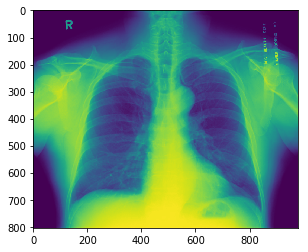

In [393]:
plt.imshow(patient)

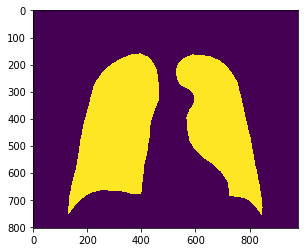

In [394]:
plt.imshow(mask)